## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
%run modules.py

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

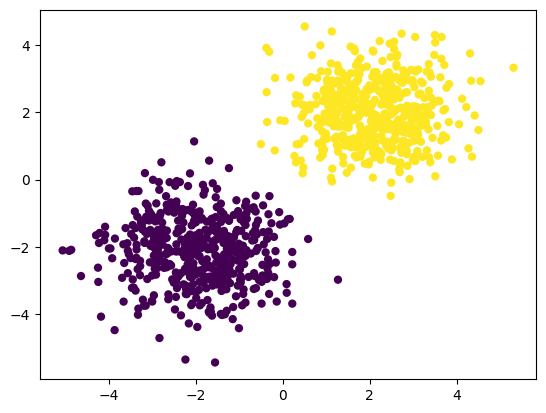

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

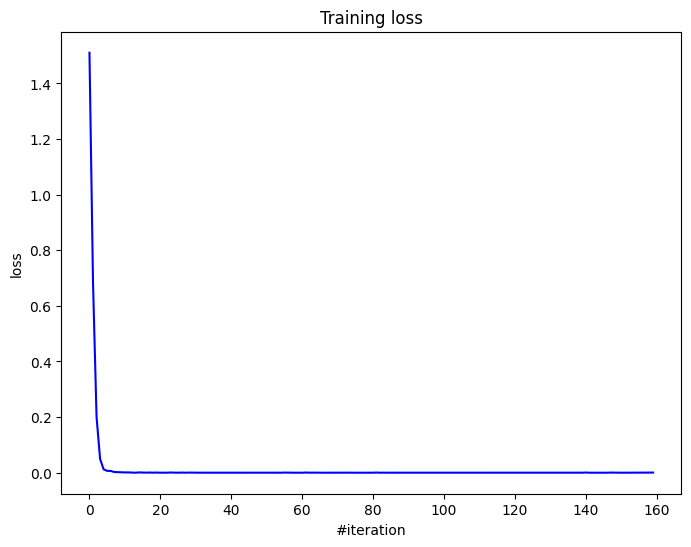

Current loss: 0.000539


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [ ]:
def fit_epoch(model, optimizer, criterion):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        model.zeroGradParameters()

        y_pred = model.forward(x_batch)
        loss = criterion.forward(y_pred, y_batch)
        dp = criterion.backward(y_pred, y_batch)
        model.backward(x_batch, dp)

        optimizer.step()
        running_loss += loss
        processed_size += len(x_batch)

    return running_loss / processed_size

In [ ]:
def eval_epoch(model, criterion):
    model.evaluate()

    running_loss = 0.0
    processed_size = 0

    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        model.zeroGradParameters()

        y_pred = model.forward(x_batch)
        loss = criterion.forward(y_pred, y_batch)

        running_loss += loss
        processed_size += len(x_batch)

    return running_loss / processed_size

In [ ]:
from tqdm import tqdm

def train(model, optimizer, criterion, epochs):
    loss_history = []
    with tqdm(total = epochs) as pbar:
        for epoch in range(epochs):
            tr_loss = fit_epoch(model, optimizer, criterion)
            val_loss = eval_epoch(model, criterion)
            loss_history.append((tr_loss, val_loss))
            print(f"Train loss: {tr_loss}, val loss: {val_loss}")

            pbar.update(1)

    return loss_history

In [ ]:
activation = [ReLU, ELU, LeakyReLU, SoftPlus]

In [ ]:
optimizer_func = [sgd_momentum, adam_optimizer]

In [ ]:
optimizer_config = {
    sgd_momentum: {
        'learning_rate' : 1e-2, 'momentum': 0.9
    },
    adam_optimizer: {
        'learning_rate' : 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8
    }
}

In [ ]:
models = {}
history = {}

In [ ]:
class Optimizer:
    def __init__(self, model, func, config, state):
        self.model = model
        self.func = func
        self.config = config
        self.state = state

    def step(self):
        self.func(self.model.getParameters(),
                  self.model.getGradParameters(),
                  self.config,
                  self.state)

In [ ]:
class SimpleNN(Sequential):
    def __init__(self, activation, batchnorm=False):
        super().__init__()

        self.add(Linear(784, 1024))

        if batchnorm:
            self.add(BatchNormalization())
            self.add(ChannelwiseScaling(1024))
        else:
            self.add(activation())
        self.add(Linear(1024, 10))

        self.add(LogSoftMax())

In [ ]:
for func in activation:
    models[func.__name__] = {}
    history[func.__name__] = {}
    for opt in optimizer_func:
        model = SimpleNN(func)
        model_bn = SimpleNN(func, batchnorm=True)
        models[func.__name__][opt.__name__] = {
            'Batchnorm': {
                'model': model_bn,
                'optimizer': Optimizer(model_bn, opt, optimizer_config[opt], {})
            },
            'No batchnorm': {
                'model': model,
                'optimizer': Optimizer(model, opt, optimizer_config[opt], {})
            }
        }
        history[func.__name__][opt.__name__] = {
            'Batchnorm': [],
            'No batchnorm': []
        }

In [ ]:
for func in activation:
    for opt in optimizer_func:
        print(f"Activation: {func.__name__}, optimizer: {opt.__name__}")
        model = models[func.__name__][opt.__name__]['No batchnorm']['model']
        optimizer = models[func.__name__][opt.__name__]['No batchnorm']['optimizer']

        model_bn = models[func.__name__][opt.__name__]['Batchnorm']['model']
        optimizer_bn = models[func.__name__][opt.__name__]['Batchnorm']['optimizer']

        criterion = ClassNLLCriterion()

        print(f"Batchnorm: true")
        history[func.__name__][opt.__name__]['Batchnorm'] = train(model_bn, optimizer_bn, criterion, 15)

        print(f"Batchnorm: false")
        history[func.__name__][opt.__name__]['No batchnorm'] = train(model, optimizer, criterion, 15)

Activation: ReLU, optimizer: sgd_momentum
Batchnorm: true


  7%|▋         | 1/15 [00:22<05:12, 22.36s/it]

Train loss: 0.010923364282273314, val loss: 0.003067978475351457


 13%|█▎        | 2/15 [00:44<04:51, 22.41s/it]

Train loss: 0.002521716683617457, val loss: 0.001961817449734304


 20%|██        | 3/15 [01:10<04:49, 24.09s/it]

Train loss: 0.0018846908587454383, val loss: 0.0015690678105632402


 27%|██▋       | 4/15 [01:32<04:12, 22.92s/it]

Train loss: 0.0015291946980177358, val loss: 0.0014738119559894057


 33%|███▎      | 5/15 [01:55<03:51, 23.16s/it]

Train loss: 0.001283225553434823, val loss: 0.0012826263536430133


 40%|████      | 6/15 [02:18<03:28, 23.20s/it]

Train loss: 0.0010891677755377114, val loss: 0.0010315446251509637


 47%|████▋     | 7/15 [02:39<02:59, 22.49s/it]

Train loss: 0.0009398719630888847, val loss: 0.0009246972287686347


 53%|█████▎    | 8/15 [03:02<02:38, 22.58s/it]

Train loss: 0.0008181572630582656, val loss: 0.0009720925249776881


 60%|██████    | 9/15 [03:22<02:10, 21.76s/it]

Train loss: 0.0007215128026031765, val loss: 0.0009636894504345146


 67%|██████▋   | 10/15 [03:43<01:46, 21.35s/it]

Train loss: 0.0006341543748879547, val loss: 0.0007785726490033805


 73%|███████▎  | 11/15 [04:05<01:26, 21.73s/it]

Train loss: 0.0005755141314847599, val loss: 0.0007295509863026158


 80%|████████  | 12/15 [04:24<01:02, 20.98s/it]

Train loss: 0.0005106418935309437, val loss: 0.0007952932760765742


 87%|████████▋ | 13/15 [04:44<00:41, 20.56s/it]

Train loss: 0.0004588089925148894, val loss: 0.0007316825399153917


 93%|█████████▎| 14/15 [05:07<00:21, 21.20s/it]

Train loss: 0.00041605423996469206, val loss: 0.0007447876320939915


100%|██████████| 15/15 [05:26<00:00, 21.79s/it]


Train loss: 0.00036982570124445763, val loss: 0.0007145704551573537
Batchnorm: false


  7%|▋         | 1/15 [00:17<04:02, 17.35s/it]

Train loss: 0.004855265788994545, val loss: 0.002381727034283727


 13%|█▎        | 2/15 [00:35<03:53, 17.97s/it]

Train loss: 0.0023251087108063563, val loss: 0.0019456620768663435


 20%|██        | 3/15 [00:55<03:44, 18.73s/it]

Train loss: 0.0019093605695236055, val loss: 0.0016448414372390804


 27%|██▋       | 4/15 [01:14<03:28, 18.92s/it]

Train loss: 0.00161926104471316, val loss: 0.001415394650953021


 33%|███▎      | 5/15 [01:32<03:07, 18.71s/it]

Train loss: 0.0013972489036441083, val loss: 0.0012739148743427006


 40%|████      | 6/15 [01:51<02:46, 18.51s/it]

Train loss: 0.0012240398412861546, val loss: 0.0011390491113222427


 47%|████▋     | 7/15 [02:09<02:27, 18.43s/it]

Train loss: 0.001090190597414053, val loss: 0.0010526559582610634


 53%|█████▎    | 8/15 [02:30<02:15, 19.36s/it]

Train loss: 0.000978958318773201, val loss: 0.0009680959952367788


 60%|██████    | 9/15 [02:48<01:54, 19.01s/it]

Train loss: 0.0008824200983827092, val loss: 0.0009319632307580355


 67%|██████▋   | 10/15 [03:07<01:34, 18.83s/it]

Train loss: 0.0008077239334299378, val loss: 0.0008667279685764767


 73%|███████▎  | 11/15 [03:25<01:13, 18.49s/it]

Train loss: 0.0007374564267216933, val loss: 0.0008230390149976383


 80%|████████  | 12/15 [03:42<00:54, 18.23s/it]

Train loss: 0.0006819884339789887, val loss: 0.0007781915484051703


 87%|████████▋ | 13/15 [04:02<00:37, 18.84s/it]

Train loss: 0.0006312508409778366, val loss: 0.0007319183548047965


 93%|█████████▎| 14/15 [04:22<00:18, 18.94s/it]

Train loss: 0.0005858401930662311, val loss: 0.0007138410048351484


100%|██████████| 15/15 [04:39<00:00, 18.66s/it]


Train loss: 0.0005461568114927593, val loss: 0.0007184320151880474
Activation: ReLU, optimizer: adam_optimizer
Batchnorm: true


  7%|▋         | 1/15 [00:25<06:00, 25.77s/it]

Train loss: 0.00386483765239736, val loss: 0.001553840720807878


 13%|█▎        | 2/15 [00:49<05:18, 24.52s/it]

Train loss: 0.0012538848936928112, val loss: 0.0011576966499333508


 20%|██        | 3/15 [01:16<05:07, 25.64s/it]

Train loss: 0.0008005968429116782, val loss: 0.0007889440465046926


 27%|██▋       | 4/15 [01:41<04:41, 25.57s/it]

Train loss: 0.0005508776258512857, val loss: 0.0007139905849017091


 33%|███▎      | 5/15 [02:07<04:14, 25.48s/it]

Train loss: 0.0003913294557916468, val loss: 0.0006044442131435821


 40%|████      | 6/15 [02:33<03:50, 25.66s/it]

Train loss: 0.00028147182372036686, val loss: 0.0007665873351583098


 47%|████▋     | 7/15 [02:57<03:23, 25.38s/it]

Train loss: 0.0002208270934681554, val loss: 0.0006322351417506928


 53%|█████▎    | 8/15 [03:22<02:56, 25.15s/it]

Train loss: 0.00016068225876542087, val loss: 0.0006390005844652588


 60%|██████    | 9/15 [03:49<02:34, 25.70s/it]

Train loss: 0.00011596266713613386, val loss: 0.0005905670757796691


 67%|██████▋   | 10/15 [04:13<02:05, 25.16s/it]

Train loss: 9.751358701468189e-05, val loss: 0.000580029365171221


 73%|███████▎  | 11/15 [04:39<01:41, 25.37s/it]

Train loss: 8.016727278178294e-05, val loss: 0.0007116150220266121


 80%|████████  | 12/15 [05:06<01:17, 25.87s/it]

Train loss: 7.415802115133461e-05, val loss: 0.0007643213920527246


 87%|████████▋ | 13/15 [05:30<00:50, 25.34s/it]

Train loss: 8.266480234392668e-05, val loss: 0.0006921537360221478


 93%|█████████▎| 14/15 [05:56<00:25, 25.47s/it]

Train loss: 5.6034709887036245e-05, val loss: 0.000732142364655182


100%|██████████| 15/15 [06:22<00:00, 25.48s/it]


Train loss: 4.215295914842124e-05, val loss: 0.0007743814225789757
Batchnorm: false


  7%|▋         | 1/15 [00:22<05:11, 22.28s/it]

Train loss: 0.0023376843112055427, val loss: 0.0011011517780802663


 13%|█▎        | 2/15 [00:45<04:59, 23.01s/it]

Train loss: 0.000891449426488992, val loss: 0.0008068639133147668


 20%|██        | 3/15 [01:06<04:23, 21.99s/it]

Train loss: 0.0005622005572797014, val loss: 0.0006088755298267329


 27%|██▋       | 4/15 [01:30<04:10, 22.73s/it]

Train loss: 0.00038828748996971114, val loss: 0.0005498419561261856


 33%|███▎      | 5/15 [01:53<03:48, 22.86s/it]

Train loss: 0.000269287906943042, val loss: 0.0005570900361921076


 40%|████      | 6/15 [02:17<03:30, 23.39s/it]

Train loss: 0.00019566499771490634, val loss: 0.0005697589930652953


 47%|████▋     | 7/15 [02:40<03:03, 23.00s/it]

Train loss: 0.00014673830262979844, val loss: 0.0005933677125466936


 53%|█████▎    | 8/15 [03:04<02:44, 23.43s/it]

Train loss: 0.0001101299544670776, val loss: 0.0005435329864808407


 60%|██████    | 9/15 [03:26<02:17, 22.97s/it]

Train loss: 7.854690532472066e-05, val loss: 0.0006311543898622658


 67%|██████▋   | 10/15 [03:50<01:57, 23.42s/it]

Train loss: 7.486080353742322e-05, val loss: 0.0005432135394514974


 73%|███████▎  | 11/15 [04:12<01:31, 22.90s/it]

Train loss: 5.730961309699459e-05, val loss: 0.0005883737742307691


 80%|████████  | 12/15 [04:36<01:09, 23.22s/it]

Train loss: 5.309240403886009e-05, val loss: 0.000634408435922202


 87%|████████▋ | 13/15 [04:58<00:45, 22.87s/it]

Train loss: 4.2339568286702705e-05, val loss: 0.0006088404771497063


 93%|█████████▎| 14/15 [05:23<00:23, 23.39s/it]

Train loss: 2.483064130295783e-05, val loss: 0.0006759367393162114


100%|██████████| 15/15 [05:45<00:00, 23.04s/it]


Train loss: 3.534182720727449e-05, val loss: 0.0007244226151639339
Activation: ELU, optimizer: sgd_momentum
Batchnorm: true


  7%|▋         | 1/15 [00:24<05:47, 24.83s/it]

Train loss: 0.008645928891863374, val loss: 0.0029787052750053942


 13%|█▎        | 2/15 [00:47<05:05, 23.46s/it]

Train loss: 0.0026425316352937144, val loss: 0.0022706875321708317


 20%|██        | 3/15 [01:12<04:50, 24.24s/it]

Train loss: 0.0023319707570986633, val loss: 0.0021124385413860674


 27%|██▋       | 4/15 [01:35<04:19, 23.57s/it]

Train loss: 0.0021435096652058987, val loss: 0.0020020884864877216


 33%|███▎      | 5/15 [01:59<04:00, 24.06s/it]

Train loss: 0.0019893815921028504, val loss: 0.0018676137283581713


 40%|████      | 6/15 [02:23<03:35, 23.96s/it]

Train loss: 0.0018308276075536148, val loss: 0.0017194936765085086


 47%|████▋     | 7/15 [02:48<03:12, 24.08s/it]

Train loss: 0.0016742357036248867, val loss: 0.0016747531117899425


 53%|█████▎    | 8/15 [03:13<02:50, 24.37s/it]

Train loss: 0.0015301713539492435, val loss: 0.0015793632443123812


 60%|██████    | 9/15 [03:35<02:23, 23.84s/it]

Train loss: 0.0014052828288402181, val loss: 0.0013945741294772984


 67%|██████▋   | 10/15 [04:01<02:01, 24.28s/it]

Train loss: 0.001287272770139713, val loss: 0.0014903761072032266


 73%|███████▎  | 11/15 [04:23<01:34, 23.70s/it]

Train loss: 0.0011864662649893605, val loss: 0.0012827822157409567


 80%|████████  | 12/15 [04:48<01:12, 24.16s/it]

Train loss: 0.0010934759794986415, val loss: 0.00117736036039026


 87%|████████▋ | 13/15 [05:11<00:47, 23.64s/it]

Train loss: 0.0009965223805625844, val loss: 0.0011887302966652898


 93%|█████████▎| 14/15 [05:36<00:24, 24.04s/it]

Train loss: 0.0009317546768216281, val loss: 0.001107632980933018


100%|██████████| 15/15 [05:58<00:00, 23.93s/it]


Train loss: 0.0008622713648293925, val loss: 0.0011360140889689174
Batchnorm: false


  7%|▋         | 1/15 [00:23<05:23, 23.13s/it]

Train loss: 0.004482430089738751, val loss: 0.002507849276931065


 13%|█▎        | 2/15 [00:43<04:39, 21.48s/it]

Train loss: 0.0025771968786851367, val loss: 0.002395216725496207


 20%|██        | 3/15 [01:06<04:28, 22.34s/it]

Train loss: 0.0023797150395083334, val loss: 0.0022668354363557615


 27%|██▋       | 4/15 [01:27<04:00, 21.86s/it]

Train loss: 0.002262960452450547, val loss: 0.00209004713048117


 33%|███▎      | 5/15 [01:49<03:38, 21.85s/it]

Train loss: 0.0021691198744036443, val loss: 0.002074569974237029


 40%|████      | 6/15 [02:12<03:18, 22.03s/it]

Train loss: 0.002082820629076822, val loss: 0.0019349496140982


 47%|████▋     | 7/15 [02:33<02:54, 21.76s/it]

Train loss: 0.0019884079683357486, val loss: 0.0018910836316860017


 53%|█████▎    | 8/15 [02:56<02:35, 22.18s/it]

Train loss: 0.0018859794146157231, val loss: 0.0018235747289751167


 60%|██████    | 9/15 [03:17<02:11, 21.85s/it]

Train loss: 0.0017827183331544068, val loss: 0.0016764105993854503


 67%|██████▋   | 10/15 [03:39<01:49, 21.91s/it]

Train loss: 0.001666264346140345, val loss: 0.0016328157801328797


 73%|███████▎  | 11/15 [04:01<01:27, 21.88s/it]

Train loss: 0.0015613728797262746, val loss: 0.00152410739821678


 80%|████████  | 12/15 [04:22<01:04, 21.53s/it]

Train loss: 0.001456995006264349, val loss: 0.0014228545338900516


 87%|████████▋ | 13/15 [04:45<00:44, 22.18s/it]

Train loss: 0.0013627648128571243, val loss: 0.0013560508328555193


 93%|█████████▎| 14/15 [05:06<00:21, 21.64s/it]

Train loss: 0.0012862239381719429, val loss: 0.0012817256961788759


100%|██████████| 15/15 [05:29<00:00, 21.94s/it]


Train loss: 0.0012021009097719438, val loss: 0.0012137444585514682
Activation: ELU, optimizer: adam_optimizer
Batchnorm: true


  7%|▋         | 1/15 [00:27<06:29, 27.81s/it]

Train loss: 0.004004133660991696, val loss: 0.002413273227404781


 13%|█▎        | 2/15 [00:55<06:03, 27.98s/it]

Train loss: 0.0022994753955946435, val loss: 0.0022544053526131515


 20%|██        | 3/15 [01:41<07:09, 35.83s/it]

Train loss: 0.0021939024461107353, val loss: 0.00203835898871722


 27%|██▋       | 4/15 [02:24<07:07, 38.90s/it]

Train loss: 0.0020948538883479428, val loss: 0.0020313856215317555


 33%|███▎      | 5/15 [03:01<06:22, 38.24s/it]

Train loss: 0.001997717210854909, val loss: 0.0019981281545339486


 40%|████      | 6/15 [03:35<05:29, 36.61s/it]

Train loss: 0.0018474394757105634, val loss: 0.001885967335605036


 47%|████▋     | 7/15 [04:08<04:44, 35.50s/it]

Train loss: 0.0016750988493382962, val loss: 0.0017178563625807708


 53%|█████▎    | 8/15 [04:56<04:35, 39.38s/it]

Train loss: 0.0014693670501296657, val loss: 0.0014515654187317935


 60%|██████    | 9/15 [05:34<03:54, 39.13s/it]

Train loss: 0.0012592983259919924, val loss: 0.001479245260347377


 67%|██████▋   | 10/15 [06:25<03:33, 42.71s/it]

Train loss: 0.001092502943079267, val loss: 0.0011515858859483146


 73%|███████▎  | 11/15 [07:13<02:56, 44.22s/it]

Train loss: 0.0009335550626001663, val loss: 0.0011547495723166425


 80%|████████  | 12/15 [07:48<02:04, 41.62s/it]

Train loss: 0.000823205198750154, val loss: 0.0009861712646857701


 87%|████████▋ | 13/15 [08:28<01:22, 41.07s/it]

Train loss: 0.000724928804795678, val loss: 0.0009910804638998715


 93%|█████████▎| 14/15 [09:06<00:40, 40.06s/it]

Train loss: 0.0006329183390121733, val loss: 0.0010624959547163202


100%|██████████| 15/15 [09:50<00:00, 39.39s/it]


Train loss: 0.000549374227655738, val loss: 0.0009343195985126494
Batchnorm: false


  7%|▋         | 1/15 [00:31<07:20, 31.44s/it]

Train loss: 0.002810124805653969, val loss: 0.0019625595466477657


 13%|█▎        | 2/15 [01:06<07:17, 33.63s/it]

Train loss: 0.001558472592379544, val loss: 0.001200541767523081


 20%|██        | 3/15 [01:43<07:02, 35.22s/it]

Train loss: 0.0010801364405741754, val loss: 0.0010333461951385617


 27%|██▋       | 4/15 [02:25<06:57, 37.94s/it]

Train loss: 0.0007830935729943155, val loss: 0.0008026014761089552


 33%|███▎      | 5/15 [02:59<06:02, 36.25s/it]

Train loss: 0.0005938379884047099, val loss: 0.0007171024411318672


 40%|████      | 6/15 [03:33<05:22, 35.79s/it]

Train loss: 0.0004838209367359143, val loss: 0.000629999246058862


 47%|████▋     | 7/15 [04:15<05:00, 37.54s/it]

Train loss: 0.0004015092354471826, val loss: 0.0007004107805682124


 53%|█████▎    | 8/15 [04:57<04:32, 38.99s/it]

Train loss: 0.0003189323025948281, val loss: 0.0006140250372079756


 60%|██████    | 9/15 [05:30<03:43, 37.19s/it]

Train loss: 0.0002579501272450335, val loss: 0.0006676691357245637


 67%|██████▋   | 10/15 [05:56<02:48, 33.75s/it]

Train loss: 0.00020612082718292826, val loss: 0.0007184558300525158


 73%|███████▎  | 11/15 [06:25<02:09, 32.34s/it]

Train loss: 0.00019095090298092658, val loss: 0.0006733164556944096


 80%|████████  | 12/15 [06:52<01:31, 30.58s/it]

Train loss: 0.00014616309496407777, val loss: 0.0006648655837502616


 87%|████████▋ | 13/15 [07:19<00:59, 29.71s/it]

Train loss: 0.00012587343138909787, val loss: 0.0007450696686518261


 93%|█████████▎| 14/15 [07:44<00:28, 28.30s/it]

Train loss: 0.00011328751512681203, val loss: 0.0006849077329951207


100%|██████████| 15/15 [08:10<00:00, 32.73s/it]


Train loss: 9.367575108248714e-05, val loss: 0.0007284934098603968
Activation: LeakyReLU, optimizer: sgd_momentum
Batchnorm: true


  7%|▋         | 1/15 [00:21<05:03, 21.66s/it]

Train loss: 0.010915320333356704, val loss: 0.0029972517775851168


 13%|█▎        | 2/15 [00:43<04:39, 21.52s/it]

Train loss: 0.002550475763324925, val loss: 0.0021290148141970533


 20%|██        | 3/15 [01:02<04:08, 20.74s/it]

Train loss: 0.0019149611287121138, val loss: 0.0015681011286322324


 27%|██▋       | 4/15 [01:25<03:54, 21.30s/it]

Train loss: 0.0015657945892747337, val loss: 0.0014841221384038672


 33%|███▎      | 5/15 [01:45<03:29, 20.96s/it]

Train loss: 0.0013002687555252162, val loss: 0.0013594068375915882


 40%|████      | 6/15 [02:05<03:06, 20.69s/it]

Train loss: 0.0011166025229023143, val loss: 0.001061551073422186


 47%|████▋     | 7/15 [02:28<02:51, 21.46s/it]

Train loss: 0.0009603607680543592, val loss: 0.001026101871241708


 53%|█████▎    | 8/15 [02:56<02:43, 23.42s/it]

Train loss: 0.0008487824911088419, val loss: 0.0009761758452686158


 60%|██████    | 9/15 [03:23<02:27, 24.52s/it]

Train loss: 0.000743578033221769, val loss: 0.0008995099489499436


 67%|██████▋   | 10/15 [03:46<02:00, 24.05s/it]

Train loss: 0.0006594435308156343, val loss: 0.0009020177840633065


 73%|███████▎  | 11/15 [04:06<01:31, 22.95s/it]

Train loss: 0.0005872042216964354, val loss: 0.0007644562095933132


 80%|████████  | 12/15 [04:28<01:07, 22.62s/it]

Train loss: 0.0005352249364783477, val loss: 0.0008810301646980386


 87%|████████▋ | 13/15 [04:52<00:46, 23.14s/it]

Train loss: 0.00047603448130217695, val loss: 0.0007301221834394037


 93%|█████████▎| 14/15 [05:30<00:27, 27.63s/it]

Train loss: 0.00042883913992091825, val loss: 0.0008292225515418529


100%|██████████| 15/15 [05:51<00:00, 23.43s/it]


Train loss: 0.0003877075080301775, val loss: 0.0007372061699454241
Batchnorm: false


  7%|▋         | 1/15 [00:18<04:19, 18.52s/it]

Train loss: 0.004856198102671233, val loss: 0.0024862914492741277


 13%|█▎        | 2/15 [00:36<03:59, 18.40s/it]

Train loss: 0.0023480407017961768, val loss: 0.0019642864747703324


 20%|██        | 3/15 [00:56<03:45, 18.80s/it]

Train loss: 0.001945722095365897, val loss: 0.0016560465378276721


 27%|██▋       | 4/15 [01:15<03:28, 18.98s/it]

Train loss: 0.0016616370500522084, val loss: 0.001469635274969524


 33%|███▎      | 5/15 [01:33<03:06, 18.61s/it]

Train loss: 0.0014404423270874696, val loss: 0.0013065932728181554


 40%|████      | 6/15 [01:51<02:46, 18.46s/it]

Train loss: 0.0012705143202401772, val loss: 0.0011891634570171431


 47%|████▋     | 7/15 [02:09<02:26, 18.36s/it]

Train loss: 0.0011321086867612086, val loss: 0.0011043946457723055


 53%|█████▎    | 8/15 [02:30<02:13, 19.02s/it]

Train loss: 0.0010090152038351524, val loss: 0.0010214533327552993


 60%|██████    | 9/15 [02:49<01:54, 19.07s/it]

Train loss: 0.0009138236322428833, val loss: 0.000935733614913255


 67%|██████▋   | 10/15 [03:07<01:33, 18.77s/it]

Train loss: 0.0008348630567181324, val loss: 0.0009063281441010829


 73%|███████▎  | 11/15 [03:25<01:14, 18.53s/it]

Train loss: 0.0007652247482628623, val loss: 0.0008373350421045185


 80%|████████  | 12/15 [03:44<00:55, 18.59s/it]

Train loss: 0.0007048902661210794, val loss: 0.000804310412395854


 87%|████████▋ | 13/15 [04:04<00:38, 19.08s/it]

Train loss: 0.0006523339468260983, val loss: 0.0008232622507807088


 93%|█████████▎| 14/15 [04:22<00:18, 18.79s/it]

Train loss: 0.0006078229109929359, val loss: 0.0007482985421814875


100%|██████████| 15/15 [04:40<00:00, 18.71s/it]


Train loss: 0.00056287575476656, val loss: 0.0007372696246822787
Activation: LeakyReLU, optimizer: adam_optimizer
Batchnorm: true


  7%|▋         | 1/15 [00:26<06:12, 26.60s/it]

Train loss: 0.003757802203278928, val loss: 0.0014703291257461514


 13%|█▎        | 2/15 [00:51<05:29, 25.32s/it]

Train loss: 0.001255276139759565, val loss: 0.0010812290312081647


 20%|██        | 3/15 [01:18<05:14, 26.22s/it]

Train loss: 0.0007979129649532918, val loss: 0.000857595652475273


 27%|██▋       | 4/15 [01:44<04:49, 26.33s/it]

Train loss: 0.0005516121097955171, val loss: 0.0007665633097693673


 33%|███▎      | 5/15 [02:08<04:15, 25.50s/it]

Train loss: 0.00039905682056894315, val loss: 0.0006780162536635216


 40%|████      | 6/15 [02:36<03:55, 26.15s/it]

Train loss: 0.0002904246733214907, val loss: 0.0006535854587960899


 47%|████▋     | 7/15 [03:02<03:28, 26.03s/it]

Train loss: 0.0002139818761724871, val loss: 0.0006901600024445055


 53%|█████▎    | 8/15 [03:26<02:58, 25.46s/it]

Train loss: 0.00015127560473473427, val loss: 0.0006318836051185669


 60%|██████    | 9/15 [03:53<02:36, 26.08s/it]

Train loss: 0.00012876880432390937, val loss: 0.0006467551581425072


 67%|██████▋   | 10/15 [04:21<02:12, 26.53s/it]

Train loss: 0.00010059713471691221, val loss: 0.0006473556409382366


 73%|███████▎  | 11/15 [04:46<01:45, 26.29s/it]

Train loss: 8.70782385692609e-05, val loss: 0.0007999607658683271


 80%|████████  | 12/15 [05:11<01:17, 25.80s/it]

Train loss: 8.036843686814016e-05, val loss: 0.0008170115797632514


 87%|████████▋ | 13/15 [05:38<00:51, 25.99s/it]

Train loss: 6.663856820860438e-05, val loss: 0.0007735856375127026


 93%|█████████▎| 14/15 [06:03<00:25, 25.87s/it]

Train loss: 6.24680452130211e-05, val loss: 0.0006918661504228332


100%|██████████| 15/15 [06:28<00:00, 25.93s/it]


Train loss: 4.9953280157216945e-05, val loss: 0.0008338516798063507
Batchnorm: false


  7%|▋         | 1/15 [00:24<05:37, 24.11s/it]

Train loss: 0.0023718616696470182, val loss: 0.001103937311610507


 13%|█▎        | 2/15 [00:46<05:01, 23.16s/it]

Train loss: 0.0009234608877591841, val loss: 0.000779659757347572


 20%|██        | 3/15 [01:12<04:51, 24.33s/it]

Train loss: 0.0005997765441483295, val loss: 0.0006644369764489464


 27%|██▋       | 4/15 [01:35<04:24, 24.05s/it]

Train loss: 0.00041456791852506164, val loss: 0.0006295155540506577


 33%|███▎      | 5/15 [02:04<04:15, 25.51s/it]

Train loss: 0.00029322357957522923, val loss: 0.0005628804529543524


 40%|████      | 6/15 [02:29<03:49, 25.55s/it]

Train loss: 0.000218726747535587, val loss: 0.000538471883326156


 47%|████▋     | 7/15 [02:53<03:19, 24.94s/it]

Train loss: 0.000157391273186855, val loss: 0.000606808336227828


 53%|█████▎    | 8/15 [03:17<02:52, 24.68s/it]

Train loss: 0.0001147026442182641, val loss: 0.0005437789524932518


 60%|██████    | 9/15 [03:41<02:27, 24.55s/it]

Train loss: 9.12529271141299e-05, val loss: 0.0005794542025597839


 67%|██████▋   | 10/15 [04:07<02:04, 24.80s/it]

Train loss: 6.435778269664355e-05, val loss: 0.0005763981948912442


 73%|███████▎  | 11/15 [04:31<01:38, 24.74s/it]

Train loss: 4.769317199749785e-05, val loss: 0.0006473686668351021


 80%|████████  | 12/15 [04:54<01:12, 24.11s/it]

Train loss: 6.66799155184228e-05, val loss: 0.0006316386047888167


 87%|████████▋ | 13/15 [05:19<00:48, 24.49s/it]

Train loss: 3.397728871440429e-05, val loss: 0.0005973964660679761


 93%|█████████▎| 14/15 [05:42<00:24, 24.00s/it]

Train loss: 2.9265768106478333e-05, val loss: 0.0006957772877904224


100%|██████████| 15/15 [06:07<00:00, 24.50s/it]


Train loss: 0.00010487726084082614, val loss: 0.000710578940872054
Activation: SoftPlus, optimizer: sgd_momentum
Batchnorm: true


  7%|▋         | 1/15 [00:26<06:16, 26.92s/it]

Train loss: 0.014278739656932212, val loss: 0.005120168387143241


 13%|█▎        | 2/15 [00:51<05:30, 25.41s/it]

Train loss: 0.0035614655480828714, val loss: 0.0026618970684699705


 20%|██        | 3/15 [01:17<05:08, 25.69s/it]

Train loss: 0.002603555280547338, val loss: 0.0022937460426038178


 27%|██▋       | 4/15 [01:44<04:47, 26.15s/it]

Train loss: 0.0023161147465469035, val loss: 0.0020567506443123318


 33%|███▎      | 5/15 [02:08<04:14, 25.47s/it]

Train loss: 0.002110935022255269, val loss: 0.001963130322720724


 40%|████      | 6/15 [02:34<03:51, 25.75s/it]

Train loss: 0.0019011889600973732, val loss: 0.0016506140472822678


 47%|████▋     | 7/15 [03:00<03:27, 25.93s/it]

Train loss: 0.0017037313002534848, val loss: 0.0016696457766584576


 53%|█████▎    | 8/15 [03:25<02:57, 25.39s/it]

Train loss: 0.0015475577320117992, val loss: 0.001559643882884502


 60%|██████    | 9/15 [03:51<02:33, 25.60s/it]

Train loss: 0.0014227718988184344, val loss: 0.0013310466959727673


 67%|██████▋   | 10/15 [04:17<02:09, 25.87s/it]

Train loss: 0.0012898328995391473, val loss: 0.0015152765969842475


 73%|███████▎  | 11/15 [04:42<01:41, 25.48s/it]

Train loss: 0.0011907535131975054, val loss: 0.0013584369913384891


 80%|████████  | 12/15 [05:08<01:17, 25.73s/it]

Train loss: 0.0010846000418138501, val loss: 0.0011772193114630808


 87%|████████▋ | 13/15 [05:34<00:51, 25.90s/it]

Train loss: 0.001031671303279579, val loss: 0.001191549203154221


 93%|█████████▎| 14/15 [05:57<00:24, 24.94s/it]

Train loss: 0.0009469759724454708, val loss: 0.0011262846176597731


100%|██████████| 15/15 [06:23<00:00, 25.57s/it]


Train loss: 0.0008811875174638743, val loss: 0.0011714913713906005
Batchnorm: false


  7%|▋         | 1/15 [00:22<05:14, 22.49s/it]

Train loss: 0.006355613402784146, val loss: 0.00300841246059117


 13%|█▎        | 2/15 [00:47<05:11, 23.93s/it]

Train loss: 0.0029261030723894293, val loss: 0.0024746064018278924


 20%|██        | 3/15 [01:09<04:39, 23.29s/it]

Train loss: 0.0026411153402946487, val loss: 0.002426429406669069


 27%|██▋       | 4/15 [01:34<04:22, 23.87s/it]

Train loss: 0.0025208894434462534, val loss: 0.002198859671701039


 33%|███▎      | 5/15 [01:57<03:56, 23.62s/it]

Train loss: 0.0024429555032765777, val loss: 0.002209804104358209


 40%|████      | 6/15 [02:22<03:34, 23.83s/it]

Train loss: 0.0023295809956135954, val loss: 0.002151003581961885


 47%|████▋     | 7/15 [02:44<03:06, 23.26s/it]

Train loss: 0.002268857490209496, val loss: 0.002020857342744184


 53%|█████▎    | 8/15 [03:08<02:45, 23.65s/it]

Train loss: 0.0021642044388380977, val loss: 0.002131337192969982


 60%|██████    | 9/15 [03:31<02:19, 23.24s/it]

Train loss: 0.002099848569139684, val loss: 0.0019149861806729135


 67%|██████▋   | 10/15 [03:55<01:58, 23.63s/it]

Train loss: 0.0020141958195122197, val loss: 0.0018868866861482452


 73%|███████▎  | 11/15 [04:19<01:34, 23.69s/it]

Train loss: 0.00192690717302901, val loss: 0.0017669049981963191


 80%|████████  | 12/15 [04:42<01:10, 23.57s/it]

Train loss: 0.0018434254284930992, val loss: 0.0017350748828396157


 87%|████████▋ | 13/15 [05:06<00:47, 23.73s/it]

Train loss: 0.0017576214827652538, val loss: 0.0016941625140140541


 93%|█████████▎| 14/15 [05:29<00:23, 23.38s/it]

Train loss: 0.0016787676691413609, val loss: 0.001660648766122634


100%|██████████| 15/15 [05:53<00:00, 23.56s/it]


Train loss: 0.001602988715964064, val loss: 0.0015177566884329525
Activation: SoftPlus, optimizer: adam_optimizer
Batchnorm: true


  7%|▋         | 1/15 [00:30<07:03, 30.26s/it]

Train loss: 0.007541625830761736, val loss: 0.0028503176457537745


 13%|█▎        | 2/15 [01:01<06:37, 30.57s/it]

Train loss: 0.0026252989259944104, val loss: 0.002219765613091876


 20%|██        | 3/15 [01:31<06:06, 30.53s/it]

Train loss: 0.0022893613478940783, val loss: 0.0021722135068874063


 27%|██▋       | 4/15 [02:01<05:33, 30.32s/it]

Train loss: 0.002104389638102079, val loss: 0.0019867729801943375


 33%|███▎      | 5/15 [02:30<04:59, 29.97s/it]

Train loss: 0.0019137838702451065, val loss: 0.0018297644703527596


 40%|████      | 6/15 [03:01<04:30, 30.10s/it]

Train loss: 0.0017220954356192632, val loss: 0.001803958650425838


 47%|████▋     | 7/15 [03:31<04:02, 30.28s/it]

Train loss: 0.0015504967386034125, val loss: 0.0015130266297083495


 53%|█████▎    | 8/15 [04:02<03:32, 30.34s/it]

Train loss: 0.001316332166479801, val loss: 0.0013758409916067938


 60%|██████    | 9/15 [04:32<03:02, 30.43s/it]

Train loss: 0.0011474179254844189, val loss: 0.001235745832184905


 67%|██████▋   | 10/15 [05:03<02:31, 30.36s/it]

Train loss: 0.0009914370704985802, val loss: 0.0011506763371382418


 73%|███████▎  | 11/15 [05:34<02:02, 30.52s/it]

Train loss: 0.0008617670570325445, val loss: 0.0010231803418681916


 80%|████████  | 12/15 [06:03<01:30, 30.20s/it]

Train loss: 0.0007596916618661431, val loss: 0.0011116539127979316


 87%|████████▋ | 13/15 [06:33<01:00, 30.26s/it]

Train loss: 0.0006417251837883735, val loss: 0.0009541538485314851


 93%|█████████▎| 14/15 [07:04<00:30, 30.25s/it]

Train loss: 0.0005774387865084751, val loss: 0.0009970330754472173


100%|██████████| 15/15 [07:33<00:00, 30.25s/it]


Train loss: 0.0005033276280033904, val loss: 0.0009430921075075057
Batchnorm: false


  7%|▋         | 1/15 [00:30<07:05, 30.38s/it]

Train loss: 0.0033642885337893413, val loss: 0.0021474492176740247


 13%|█▎        | 2/15 [00:59<06:26, 29.76s/it]

Train loss: 0.0018382135290395008, val loss: 0.0013741485407051284


 20%|██        | 3/15 [01:27<05:46, 28.91s/it]

Train loss: 0.0012840225066563192, val loss: 0.0011385244106253162


 27%|██▋       | 4/15 [01:53<05:06, 27.83s/it]

Train loss: 0.000972789180133023, val loss: 0.0009325799762127609


 33%|███▎      | 5/15 [02:21<04:37, 27.74s/it]

Train loss: 0.0007544891695777815, val loss: 0.0007586458440099348


 40%|████      | 6/15 [02:50<04:14, 28.31s/it]

Train loss: 0.0005987933112944103, val loss: 0.0007104243437232265


 47%|████▋     | 7/15 [03:20<03:49, 28.63s/it]

Train loss: 0.0004743725318504714, val loss: 0.0006790991446424748


 53%|█████▎    | 8/15 [03:48<03:20, 28.66s/it]

Train loss: 0.0003973930919323688, val loss: 0.0006458094784816647


 60%|██████    | 9/15 [04:17<02:52, 28.74s/it]

Train loss: 0.0003350466339510979, val loss: 0.0006039325273242069


 67%|██████▋   | 10/15 [04:45<02:22, 28.41s/it]

Train loss: 0.0002673605016597299, val loss: 0.0005868333208735232


 73%|███████▎  | 11/15 [05:12<01:52, 28.13s/it]

Train loss: 0.00021228374570748663, val loss: 0.0006038710725013471


 80%|████████  | 12/15 [05:41<01:24, 28.20s/it]

Train loss: 0.00017542625224856214, val loss: 0.0006479176752056049


 87%|████████▋ | 13/15 [06:10<00:57, 28.56s/it]

Train loss: 0.00014976607065546996, val loss: 0.0006220612308536079


 93%|█████████▎| 14/15 [06:39<00:28, 28.64s/it]

Train loss: 0.00012315790553135757, val loss: 0.0006234466618205867


100%|██████████| 15/15 [07:08<00:00, 28.57s/it]

Train loss: 9.252696618359746e-05, val loss: 0.0006135714810455353


Сначала сравним скор обученных моделей на валидационной выборке. Считать итоговое значение метрики на тестовой выборке мы будем скорее всего на той модели, где скор наибольший. Но перед этим мы сначала сравним графики обучения моделей, и возможно, в качестве итоговой модели выберем другую, у которой скор на валидации будет чуть меньше.

In [ ]:
def get_accuracy_score(model):
    model.evaluate()

    correct = 0
    processed_size = 0

    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        y_pred = model.forward(x_batch)
        preds = np.argmax(y_pred, axis=1)

        correct += np.sum(preds == np.argmax(y_batch, axis=1))
        processed_size += len(x_batch)

    return correct / processed_size

In [ ]:
for func in activation:
    for opt in optimizer_func:
        model = models[func.__name__][opt.__name__]['No batchnorm']['model']
        model_bn = models[func.__name__][opt.__name__]['Batchnorm']['model']

        print(f"Activation: {func.__name__}, optimizer: {opt.__name__}, batchnorm: true. Accuracy score: {get_accuracy_score(model_bn)}")
        print(f"Activation: {func.__name__}, optimizer: {opt.__name__}, batchnorm: false. Accuracy score: {get_accuracy_score(model)}")

Activation: ReLU, optimizer: sgd_momentum, batchnorm: true. Accuracy score: 0.9737
Activation: ReLU, optimizer: sgd_momentum, batchnorm: false. Accuracy score: 0.9745
Activation: ReLU, optimizer: adam_optimizer, batchnorm: true. Accuracy score: 0.9783
Activation: ReLU, optimizer: adam_optimizer, batchnorm: false. Accuracy score: 0.9789
Activation: ELU, optimizer: sgd_momentum, batchnorm: true. Accuracy score: 0.9624
Activation: ELU, optimizer: sgd_momentum, batchnorm: false. Accuracy score: 0.9586
Activation: ELU, optimizer: adam_optimizer, batchnorm: true. Accuracy score: 0.9671
Activation: ELU, optimizer: adam_optimizer, batchnorm: false. Accuracy score: 0.9797
Activation: LeakyReLU, optimizer: sgd_momentum, batchnorm: true. Accuracy score: 0.9712
Activation: LeakyReLU, optimizer: sgd_momentum, batchnorm: false. Accuracy score: 0.9746
Activation: LeakyReLU, optimizer: adam_optimizer, batchnorm: true. Accuracy score: 0.9757
Activation: LeakyReLU, optimizer: adam_optimizer, batchnorm: 

Таким образом, наибольшее значение accuracy на валидации достигается на сетке с функцией активации SoftPlus без батчнорма и оптимизатором Adam.

In [ ]:
import seaborn as sns

def handle_history(history):
    sns.set(style="whitegrid", font_scale=1.4)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

    hist = history['No batchnorm']
    tr_loss = np.array(hist)[:, 0]
    val_loss = np.array(hist)[:, 1]

    hist_bn = history['Batchnorm']
    tr_loss_bn = np.array(hist_bn)[:, 0]
    val_loss_bn = np.array(hist_bn)[:, 1]

    ax[0].plot(tr_loss, label='No batchnorm')
    ax[0].plot(tr_loss_bn, label='With batchnorm')
    ax[0].set_title('Train')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()


    ax[1].plot(val_loss, label='No batchnorm')
    ax[1].plot(val_loss_bn, label='With batchnorm')
    ax[1].set_title('Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.show()

Activation: ReLU, optimizer: sgd_momentum, batchnorm: true
Activation: ReLU, optimizer: sgd_momentum, batchnorm: false


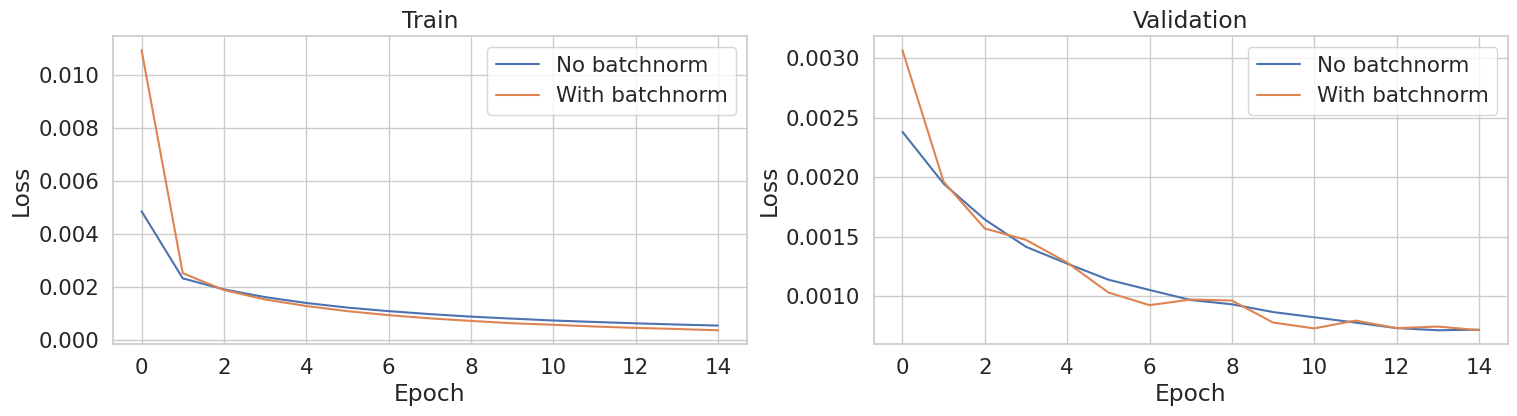

Activation: ReLU, optimizer: adam_optimizer, batchnorm: true
Activation: ReLU, optimizer: adam_optimizer, batchnorm: false


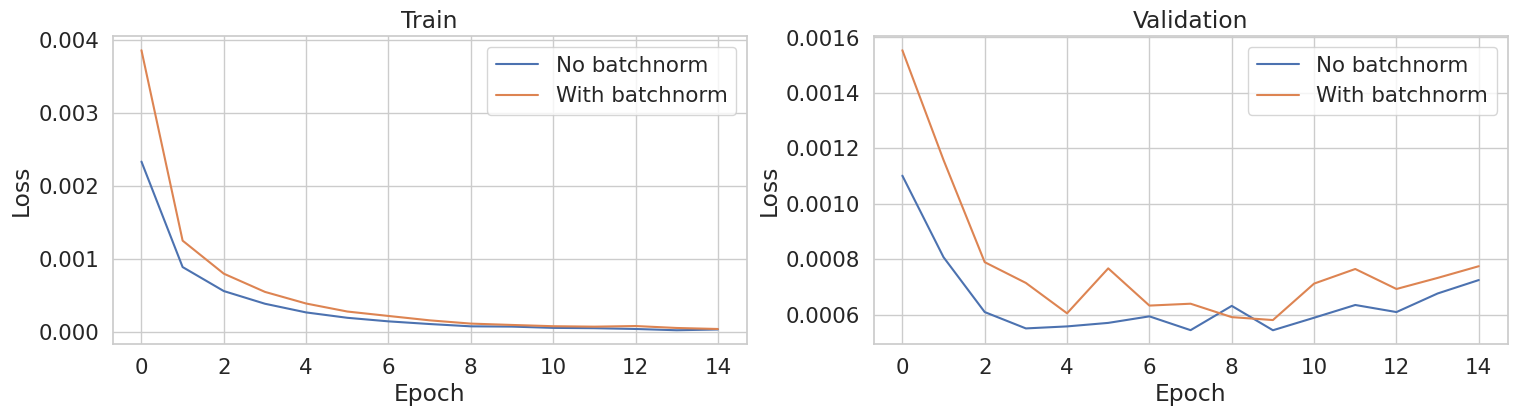

Activation: ELU, optimizer: sgd_momentum, batchnorm: true
Activation: ELU, optimizer: sgd_momentum, batchnorm: false


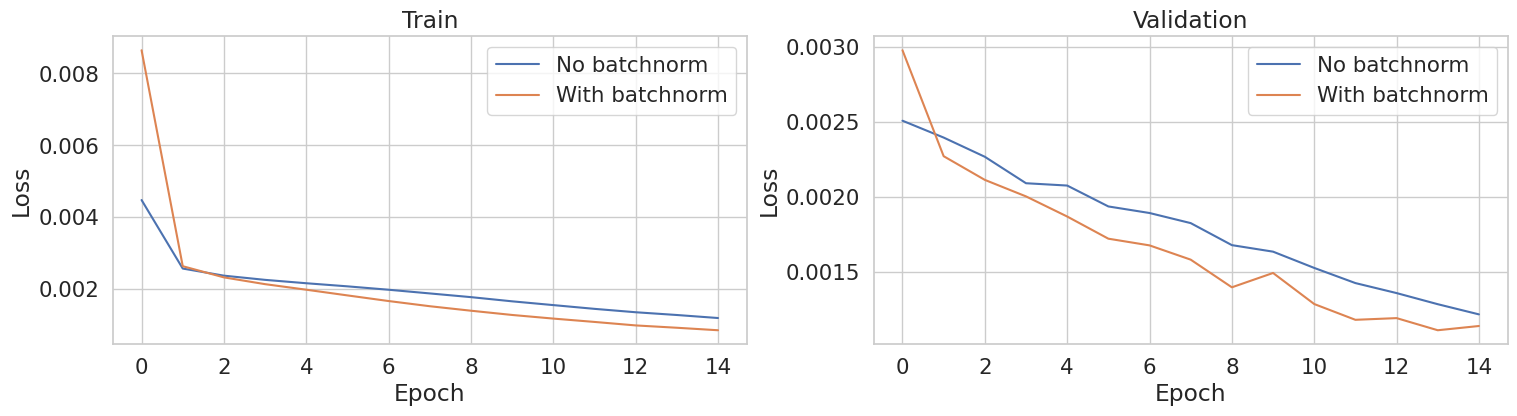

Activation: ELU, optimizer: adam_optimizer, batchnorm: true
Activation: ELU, optimizer: adam_optimizer, batchnorm: false


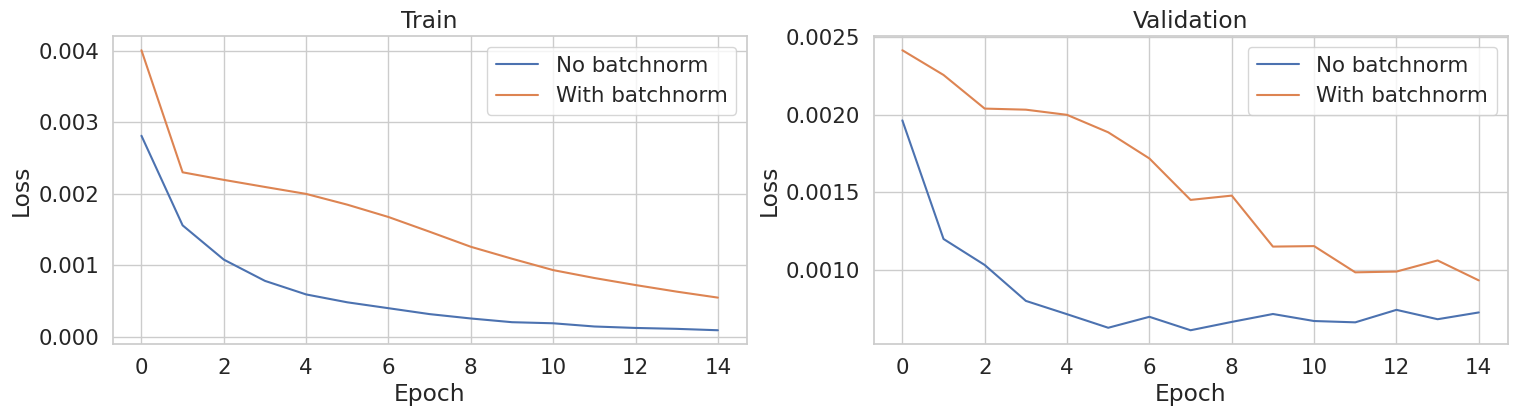

Activation: LeakyReLU, optimizer: sgd_momentum, batchnorm: true
Activation: LeakyReLU, optimizer: sgd_momentum, batchnorm: false


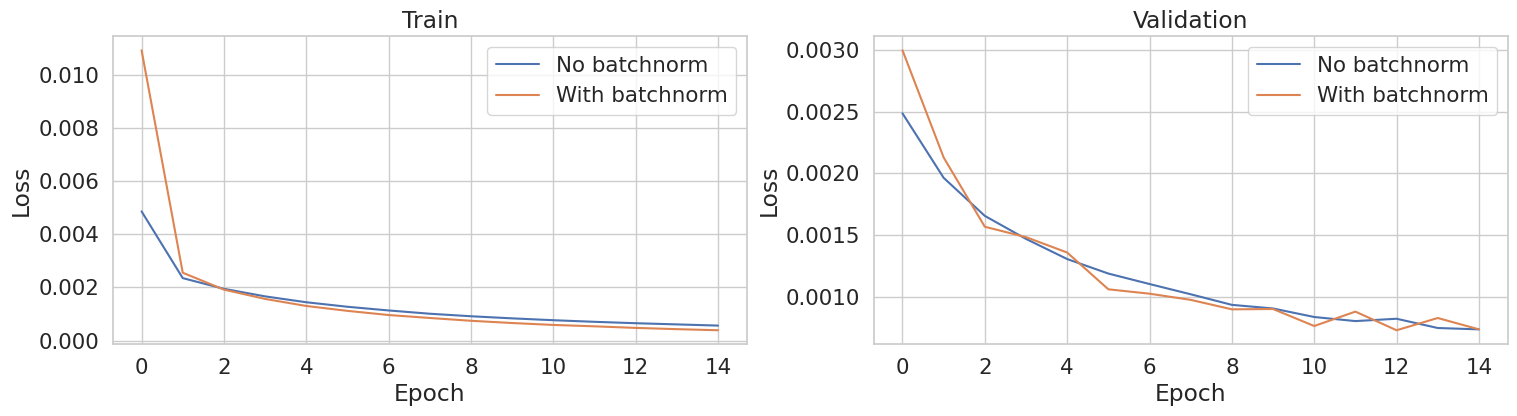

Activation: LeakyReLU, optimizer: adam_optimizer, batchnorm: true
Activation: LeakyReLU, optimizer: adam_optimizer, batchnorm: false


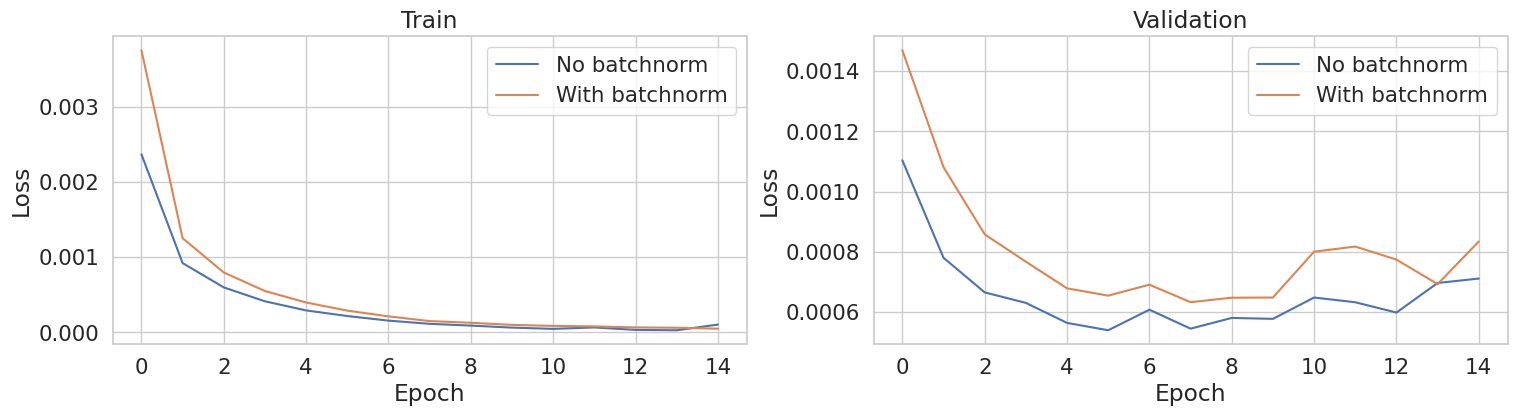

Activation: SoftPlus, optimizer: sgd_momentum, batchnorm: true
Activation: SoftPlus, optimizer: sgd_momentum, batchnorm: false


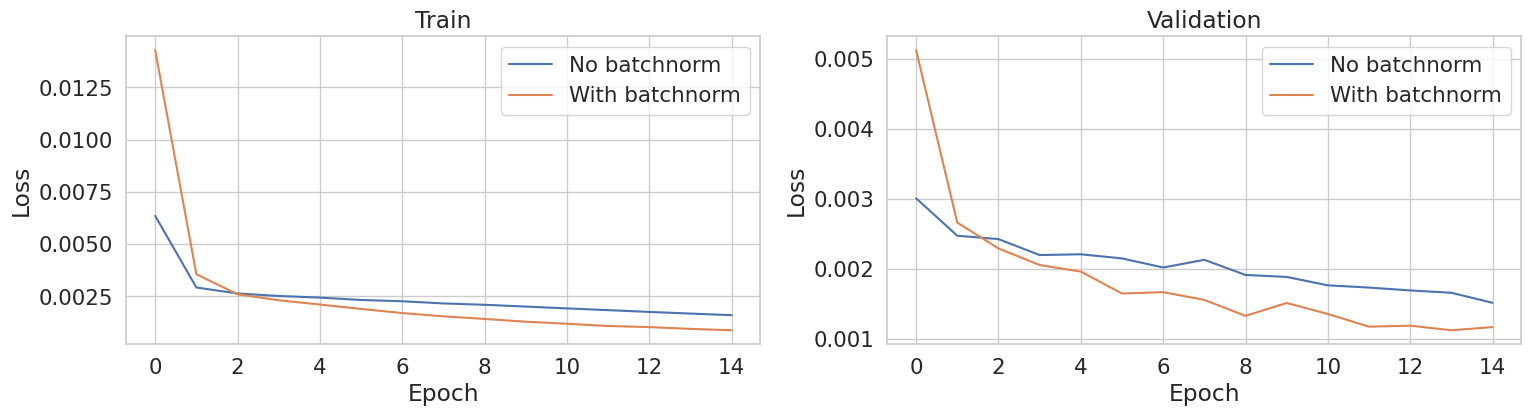

Activation: SoftPlus, optimizer: adam_optimizer, batchnorm: true
Activation: SoftPlus, optimizer: adam_optimizer, batchnorm: false


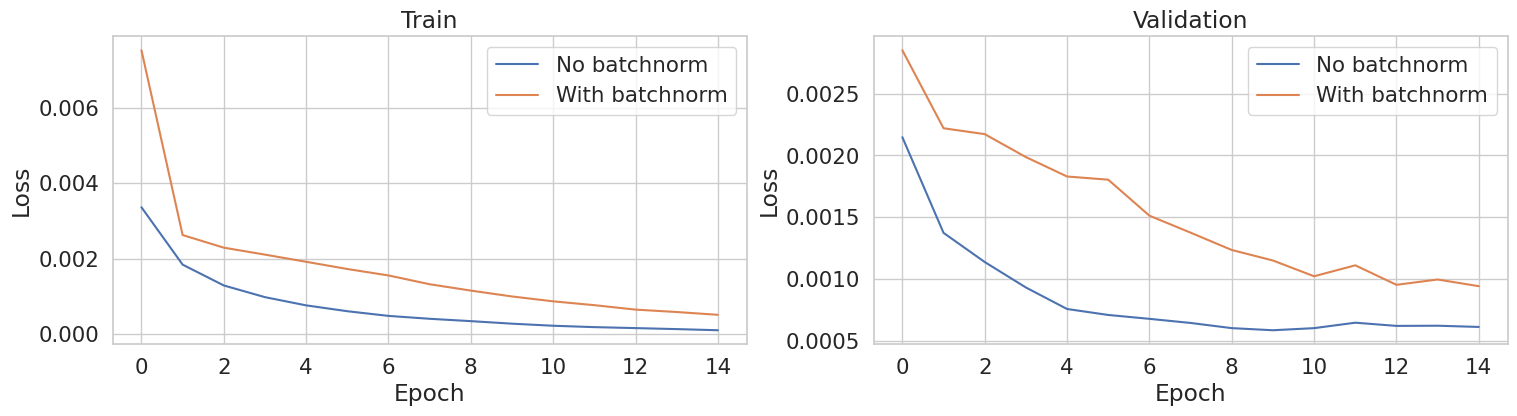

In [ ]:
for func in activation:
    for opt in optimizer_func:
        model = models[func.__name__][opt.__name__]['No batchnorm']['model']
        model_bn = models[func.__name__][opt.__name__]['Batchnorm']['model']

        print(f"Activation: {func.__name__}, optimizer: {opt.__name__}, batchnorm: true")
        print(f"Activation: {func.__name__}, optimizer: {opt.__name__}, batchnorm: false")

        hist = history[func.__name__][opt.__name__]
        handle_history(hist)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Таким образом, ответ на вопрос, полезно ли применение батчнорма, зависит от используемой функции активации и оптимизатора. Каких-то особых отличий типа скачков, "гладкости" функции потерь, явных признаков переобучения я выделить не могу. Разве что на двух моделях (ReLU и LeakyReLU с оптимизатором adam) лосс под конец обучения начал немного возрастать. Возможно, стоило добавить ещё эпох для проверки, действительно ли модель начинает переобучаться. С использованием оптимизатора Adam удаётся достичь меньшего значения лосса, чем с использованием sgd_momentum.

**Замечание.** Также можно было построить графики скора на валидации, но я задумался об этом лишь под конец обучения моделей, когда прошло уже ~1.5 часа. В целом, скор на последней эпохе обучения достаточно информативен.

Итак, исходя из всего вышесказанного, итоговый на инференсе будем считать на модели с наибольшим скором на валидации.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Скор на валидации и так достаточно хорош, поэтому дополнительные оптимизации сильно его не увеличат. На выбранной модели для инференсаа признаков переобучения не замечено, поэтому бороться с ним я так же не вижу смысла.

Print here your accuracy on test set. It should be around 90%.

In [ ]:
net = models['SoftPlus']['adam_optimizer']['No batchnorm']['model']
net.evaluate()
res = net.forward(X_test)

In [ ]:
score = np.sum(np.argmax(res, axis=1) == np.argmax(y_test, axis=1)) / len(res)
print(f"Inference score: {score}")

Inference score: 0.9814


На тесте также выбили высокий скор.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.Softplus(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        outputs = self.model(x)

        return F.log_softmax(outputs)

In [ ]:
def get_accuracy_score(model, data_loader):
    model.eval()

    correct = 0
    processed_size = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_pred = model.forward(x_batch)
            preds = np.argmax(y_pred, axis=1)
            correct += torch.sum(preds == y_batch)
            processed_size += len(x_batch)

    return correct / processed_size

In [ ]:
def fit_epoch(model, optimizer, train_loader, criterion):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for X, y in train_loader:
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_size += len(X)

    return running_loss / processed_size

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():
        for X, y in val_loader:
            preds = model(X)
            loss = criterion(preds, y, reduction='sum')

            running_loss += loss.item()
            processed_size += len(X)

    return running_loss / processed_size

In [ ]:
def train(model, optimizer, train_loader, val_loader, criterion, epochs):
    loss_history = []
    score_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = fit_epoch(model, optimizer, train_loader, criterion)
            val_loss = eval_epoch(model, val_loader, criterion)
            loss_history.append((train_loss, val_loss))
            print(f"Train loss: {train_loss}, val loss: {val_loss}")

            train_score = get_accuracy_score(model, train_loader)
            val_score = get_accuracy_score(model, val_loader)
            score_history.append((train_score, val_score))
            print(f"Train score: {train_score}, val score: {val_score}")

            pbar.update(1)

    return loss_history, score_history

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
train_loader = DataLoader(tuple(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(tuple(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(tuple(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
net = NN()
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
loss_f = F.cross_entropy

loss_hist, score_hist = train(net, opt, train_loader, val_loader, loss_f, 15)

  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-86-a376ec9f7b4c>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outputs)


Train loss: 0.0033853262957930564, val loss: 0.2418186942279339


  7%|▋         | 1/15 [00:13<03:10, 13.64s/it]

Train score: 0.9244599938392639, val score: 0.9311000108718872
Train loss: 0.0018101830400526523, val loss: 0.17855881526470185


 13%|█▎        | 2/15 [00:24<02:38, 12.16s/it]

Train score: 0.9473999738693237, val score: 0.95169997215271
Train loss: 0.0012892031217366458, val loss: 0.15103202840089797


 20%|██        | 3/15 [00:35<02:16, 11.40s/it]

Train score: 0.9575999975204468, val score: 0.9569000005722046
Train loss: 0.0009643150469660759, val loss: 0.11593804572820664


 27%|██▋       | 4/15 [00:45<02:01, 11.02s/it]

Train score: 0.9702799916267395, val score: 0.9675999879837036
Train loss: 0.0007606355849280954, val loss: 0.09919398554712534


 33%|███▎      | 5/15 [00:56<01:50, 11.05s/it]

Train score: 0.9772599935531616, val score: 0.9704999923706055
Train loss: 0.0005875917446985841, val loss: 0.10020028367415071


 40%|████      | 6/15 [01:08<01:40, 11.14s/it]

Train score: 0.9792799949645996, val score: 0.9710999727249146
Train loss: 0.00048645196408033374, val loss: 0.08737256088666617


 47%|████▋     | 7/15 [01:18<01:26, 10.82s/it]

Train score: 0.9846600294113159, val score: 0.9743000268936157
Train loss: 0.0004036889308411628, val loss: 0.08748887246642262


 53%|█████▎    | 8/15 [01:28<01:14, 10.66s/it]

Train score: 0.9866399765014648, val score: 0.9732000231742859
Train loss: 0.0003280645340867341, val loss: 0.08246804858893156


 60%|██████    | 9/15 [01:40<01:05, 10.91s/it]

Train score: 0.9898399710655212, val score: 0.9753000140190125
Train loss: 0.000270643047131598, val loss: 0.07994524174723774


 67%|██████▋   | 10/15 [01:51<00:54, 10.96s/it]

Train score: 0.9920200109481812, val score: 0.9775999784469604
Train loss: 0.00022077499792911112, val loss: 0.08352680691331625


 73%|███████▎  | 11/15 [02:01<00:43, 10.90s/it]

Train score: 0.992900013923645, val score: 0.9753000140190125
Train loss: 0.00018898901086999103, val loss: 0.08188371533397586


 80%|████████  | 12/15 [02:12<00:32, 10.87s/it]

Train score: 0.9938600063323975, val score: 0.9769999980926514
Train loss: 0.00014825202238280327, val loss: 0.08043195064340253


 87%|████████▋ | 13/15 [02:24<00:22, 11.00s/it]

Train score: 0.9952999949455261, val score: 0.9776999950408936
Train loss: 0.00011472035631304607, val loss: 0.08034935497236438


 93%|█████████▎| 14/15 [02:35<00:11, 11.17s/it]

Train score: 0.997160017490387, val score: 0.9789000153541565
Train loss: 0.00010022144235204905, val loss: 0.07846681640818715


100%|██████████| 15/15 [02:47<00:00, 11.15s/it]

Train score: 0.9970800280570984, val score: 0.9790999889373779


In [ ]:
def handle_history(loss_history, score_history):
    sns.set(style="whitegrid", font_scale=1.4)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

    tr_loss = np.array(loss_history)[:, 0]
    val_loss = np.array(loss_history)[:, 1]

    tr_score = np.array(score_history)[:, 0]
    val_score = np.array(score_history)[:, 1]

    ax[0].plot(tr_loss, label='train')
    ax[0].plot(val_loss, label='val')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[0].set_yscale('log')


    ax[1].plot(tr_score, label='train')
    ax[1].plot(val_score, label='val')
    ax[1].set_ylabel('Score')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.show()

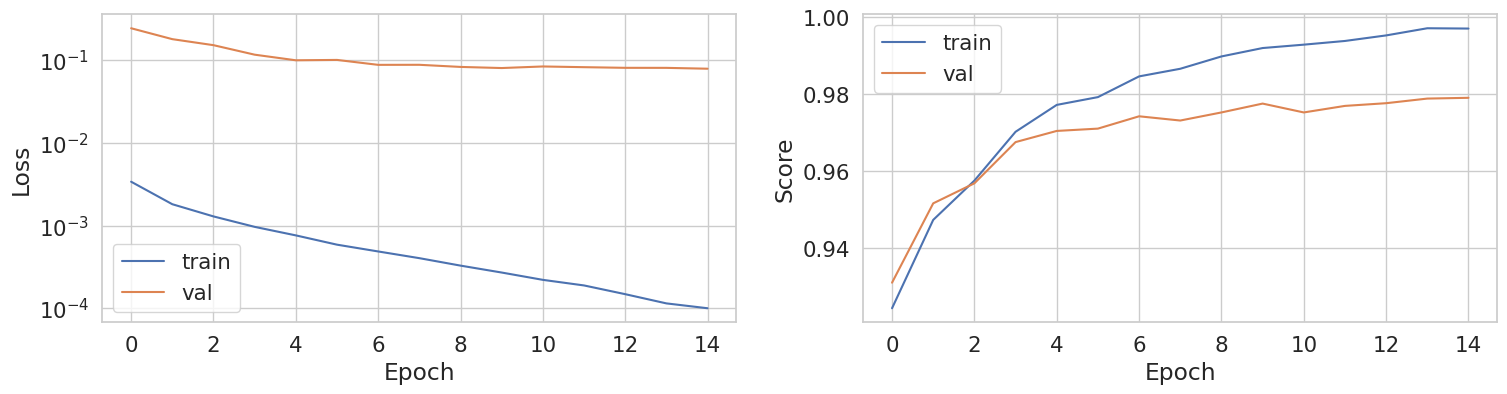

In [ ]:
handle_history(loss_hist, score_hist)

In [ ]:
score = get_accuracy_score(net, test_loader)
print(f"Inference score: {score}")

<ipython-input-86-a376ec9f7b4c>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outputs)


Inference score: 0.9779999852180481


Результат чуть хуже, чем с использованием нашей собственной реализации. Нельзя было ожидать тот же скор, поскольку, очевидно, реализация функций в pytorch может отличаться от нашей в некоторых тонкостях.